In [85]:
#librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [86]:
#lectura de datos
data = pd.read_csv(r"Datos/dataset.csv")
labels = pd.read_csv(r"Datos/labels.csv")

In [87]:
data_limpio = data.copy(deep=True)
data_limpio.drop('En.Anterior.', inplace=True, axis=1)

var_thr = VarianceThreshold(threshold = 0.01)

var_thr.fit(data_limpio.iloc[:,2: ])
var_thr.get_support()
concol = [column for column in data_limpio.iloc[:,2: ].columns 
          if column not in data_limpio.iloc[:,2: ].columns[var_thr.get_support()]]


data_limpio.drop(concol, inplace=True, axis=1)
data_numeric = pd.get_dummies(data['idEye'])
data_num = pd.concat([data , data_numeric], axis=1).reindex(data.index)
data_num.drop(columns=['idEye', 'En.Anterior.'], axis=1, inplace=True)

le = LabelEncoder()
data_le = data_limpio.copy(deep = True)
label = le.fit_transform(data_le['idEye'].values)
data_le.drop('idEye', axis=1, inplace=True)
data_le['idEye'] = label

X =data_le.iloc[:,2:].values
y= labels.iloc[:,-1].values

for i in range(X.shape[1]):
    X[:,i] = le.fit_transform(X[:,i])
y = le.fit_transform(y)

standard_scaler = StandardScaler()

X = standard_scaler.fit_transform(X)
classes = np.unique(y)
nClasses = len(classes)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80,random_state=42)

### **Entrenamiento**

Entrenamos un modelo sencillo, con nuestro dataset ya algo limpio.

In [88]:
trainedforest = RandomForestClassifier(n_estimators=500,
                                       random_state = None,
                                       n_jobs = -1).fit(X_train,y_train)

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        59
           1       0.97      0.99      0.98       508
           2       0.92      0.77      0.84        43
           3       1.00      0.96      0.98        23

    accuracy                           0.96       633
   macro avg       0.95      0.90      0.92       633
weighted avg       0.96      0.96      0.96       633



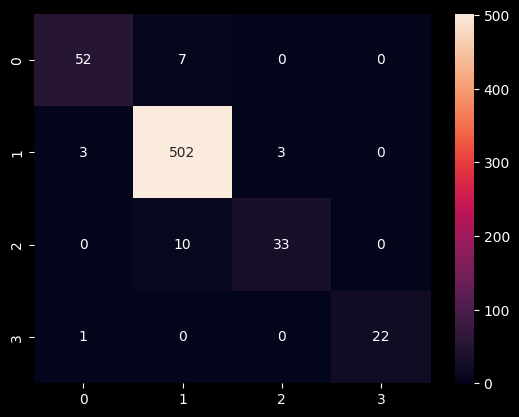

In [89]:
predictionforest = trainedforest.predict(X_test)    #para la inferencia

sns.heatmap(confusion_matrix(y_test, predictionforest), annot = True, fmt = 'g')    #Una matriz de confusión, para ver el desempeño
print(classification_report(y_test, predictionforest))  #reporte del modelo

##### - **Hiperparámetros del RandomForest**
Utilizando los paramétros de nuestra optimización, podemos intentar mejorar el modelo

##### - **GridSearch**

In [90]:
trainedforestGS = RandomForestClassifier(n_estimators=400,
                                        min_samples_split= 2,
                                        min_samples_leaf= 1,
                                        max_features = 'sqrt',
                                        max_depth= None,
                                        bootstrap= False,
                                        random_state = None,
                                        n_jobs=-1).fit(X_train,y_train)

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        59
           1       0.97      0.99      0.98       508
           2       0.92      0.77      0.84        43
           3       1.00      0.96      0.98        23

    accuracy                           0.96       633
   macro avg       0.95      0.90      0.92       633
weighted avg       0.96      0.96      0.96       633



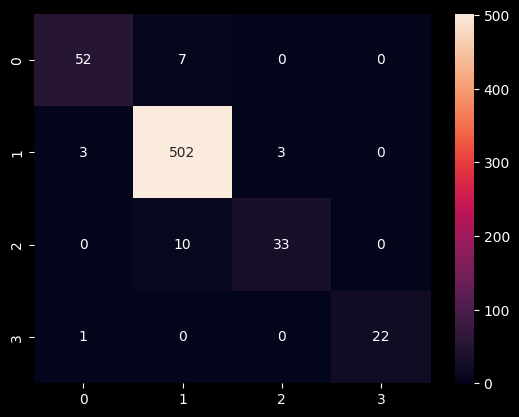

In [91]:
predictionforest1 = trainedforestGS.predict(X_test)

sns.heatmap(confusion_matrix(y_test, predictionforest), annot = True, fmt = 'g')
print(classification_report(y_test, predictionforest))

##### - **RandomizedSearch**

In [92]:
trainedforestRS = RandomForestClassifier(n_estimators= 693,
                                    max_depth= 105,
                                    max_features= 'sqrt',
                                    min_samples_leaf= 4,
                                    min_samples_split=7,
                                    bootstrap= False,
                                    n_jobs=-1).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        59
           1       0.97      0.99      0.98       508
           2       0.92      0.77      0.84        43
           3       1.00      0.96      0.98        23

    accuracy                           0.96       633
   macro avg       0.95      0.90      0.92       633
weighted avg       0.96      0.96      0.96       633



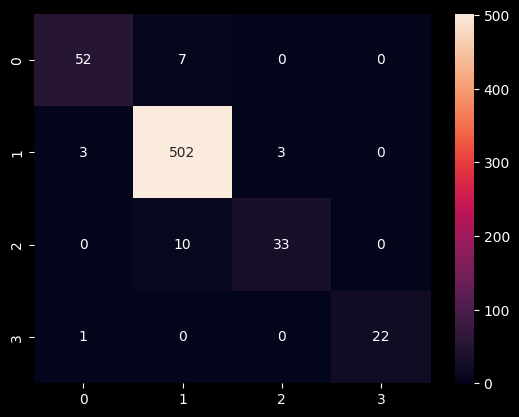

In [93]:
predictionforest2 = trainedforestRS.predict(X_test) # inferencia

sns.heatmap(confusion_matrix(y_test, predictionforest), annot = True, fmt = 'g')    # matriz de confusión
print(classification_report(y_test, predictionforest))  # reporte del modelo

###  **Mejores variables**

In [94]:
standard_scaler = StandardScaler()
data_le2 = standard_scaler.fit_transform(data_le)

bestfeatures = SelectKBest(score_func = f_classif, k = 10)  # las 10 mejores variables
fit = bestfeatures.fit(data_le,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data_le.columns)

# 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nsmallest(50,'Score'))

              Specs     Score
87              X.1  0.030974
136  Kf.6mm..Axis.1  0.109074
160             X.6  0.118163
157             X.5  0.172489
98     Ks.6mm..Axis  0.243469
134  Ks.6mm..Axis.1  0.458998
85                X  0.523366
202            X.10  0.528028
128  Ks.0mm..Axis.1  0.675097
415           idEye  0.681758
170  Ks.6mm..Axis.2  0.904840
342          OffY.1  1.043961
209            X.12  1.248340
69   Regular.Axis.5  1.347511
166  Kf.0mm..Axis.2  1.383071
21        Kf.Axis.2  1.545354
94     Kf.0mm..Axis  1.678202
4           Kf.Axis  1.700406
13        Kf.Axis.1  1.700406
130  Kf.0mm..Axis.1  1.713013
35        LocationX  1.729454
215            X.14  1.906511
19        Ks.Axis.2  1.928462
29        Kf.Axis.3  2.090288
63   Regular.Axis.4  2.148663
233            X.18  2.165515
212            X.13  2.253056
341          OffX.1  2.436326
227            X.16  2.590206
199             X.9  2.662821
241        Ecc.4mm.  3.190621
289     LocationX.1  3.279508
206       

In [95]:
X = data_le.iloc[:,2:] #creating input features
full_data = X.copy()
full_data['labels'] = y
full_data.head(10)

,Ks.Axis,Kf,Kf.Axis,AvgK,CYL,AA,Ecc.9.0mm.,ACCP,Ks.1,Ks.Axis.1,...,coma.axis.5,SA.C40..5,S35.coma.like..5,S46.sph..like..5,HOAs.S3456..5,AA.5,ESI.Anterior.,ESI.Posterior.,idEye,labels
0,21,39.22,111,41.87,5.32,86.7,0.91,41.67,49.61,21,...,97,-0.722,3.350,1.053,3.512,99,45,27,1638,0
1,39,42.46,129,43.15,1.38,88.2,0.65,43.14,48.84,39,...,97,0.085,0.921,0.290,0.966,100,0,0,1637,1
2,66,44.41,156,44.61,0.40,83.0,0.48,44.70,49.92,66,...,9,0.268,0.263,0.640,0.692,100,0,0,1822,1
3,51,42.31,141,43.15,1.69,97.3,0.60,43.16,49.01,51,...,275,-0.281,3.396,1.419,3.680,100,0,29,2204,0
4,26,45.20,116,45.31,0.22,93.3,0.69,45.29,50.60,26,...,85,0.109,0.691,0.181,0.714,100,0,7,2203,1
5,68,42.51,158,52.74,20.47,95.5,0.25,49.96,70.17,68,...,45,-1.581,13.387,9.154,16.218,98,95,0,2399,1
6,85,42.86,175,43.54,1.37,96.7,0.43,43.55,49.27,85,...,88,0.105,0.398,0.376,0.548,100,0,0,2398,1
7,170,43.75,80,44.18,0.86,97.9,0.46,44.14,49.70,170,...,20,0.375,0.437,0.360,0.566,100,0,52,2592,1
8,174,43.03,84,43.58,1.10,97.2,0.46,43.52,49.16,174,...,229,0.353,0.371,0.485,0.611,100,0,63,2593,1
9,165,45.37,75,45.60,0.46,96.8,0.80,45.60,51.05,165,...,74,0.269,0.330,0.315,0.457,100,0,24,2968,1


In [96]:
importancia = full_data.drop('labels', axis=1).apply(lambda x: x.corr(full_data.labels))
indices = np.argsort(importancia)
importancia[indices]

C:\Users\zahid\AppData\Local\Temp\ipykernel_23160\3774559747.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  importancia[indices]


X270deg      -0.569090
Apex.3       -0.568029
Apex         -0.568029
X225deg      -0.562127
X315deg      -0.551746
                ...   
Kf.1          0.325671
Kf.4          0.325708
Kf            0.325708
Avg_H.5mm.    0.328171
KCI           0.334041
Length: 414, dtype: float64

In [97]:
names=full_data.columns


l=[]
for i in range(0, len(indices)):
    if np.abs(importancia[i])>0.2:
        l.append(names[i])
print(l)

['Kf', 'AvgK', 'Ecc.9.0mm.', 'ACCP', 'Ks.1', 'Kf.1', 'AvgK.1', 'Ecc.9.0mm..1', 'Kf.2', 'AvgK.2', 'AA.2', 'Ks.3', 'Kf.3', 'AvgK.3', 'AA.3', 'Apex', 'Thinnest', 'Spherical', 'Spherical.1', 'Spherical.2', 'Spherical.3', 'Spherical.4', 'HigherOrder.4', 'Spherical.5', 'HigherOrder.5', 'Spherical.6', 'Spherical.7', 'ApexK', 'Ks.0mm.', 'Kf.0mm.', 'AvgK.0mm.', 'OSI.9mm.', 'CSI', 'ACP.3mm.', 'ApexK.1', 'Kf.0mm..1', 'AvgK.0mm..1', 'CSI.1', 'ACP.3mm..1', 'ApexK.2', 'Ks.0mm..2', 'Kf.0mm..2', 'AvgK.0mm..2', 'CSI.2', 'ACP.3mm..2', 'Highest.0mm.3mm.', 'RMS_E.3mm.', 'RMS_E.4mm.', 'RMS_E.5mm.', 'RMS_E.6mm.', 'SR_E.4mm..1', 'Ecc.9mm.', 'Ecc.12mm.', 'Ecc.15mm.', 'Avg_H.5mm.', 'Avg_H.6mm.', 'Avg_H.7mm.', 'Avg_H.8mm.', 'Avg_H.9mm.', 'SR_H.3mm..1', 'SR_H.4mm..1', 'SR_H.5mm..1', 'SR_H.6mm..1', 'Avg_H.5mm..1', 'Avg_H.6mm..1', 'Avg_H.7mm..1', 'Avg_T.6mm.', 'Sph..Keratometric.', 'Sph..Posterior.', 'Hio..Posterior.', 'Thinnest.1', 'Score.Anterior.', 'Height.Avg..Angle0.360.Dia8.FlatRate0.', 'Ks.4', 'Kf.4', 'OSI'

C:\Users\zahid\AppData\Local\Temp\ipykernel_23160\238368736.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.abs(importancia[i])>0.2:


In [98]:
X = full_data[l]
X

,Kf,AvgK,Ecc.9.0mm.,ACCP,Ks.1,Kf.1,AvgK.1,Ecc.9.0mm..1,Kf.2,AvgK.2,...,BFS.4mm.,BFS.5mm.,BFS.6mm.,BFS.7mm.,BFS.8mm.,BFS.1mm..1,SA.C40..1,SA.C40..3,SA.C40..5,ESI.Anterior.
0,39.22,41.87,0.91,41.67,49.61,43.69,46.65,0.91,-6.88,-7.08,...,7.92,8.00,8.16,8.44,8.71,5.75,-0.893,0.117,-0.722,45
1,42.46,43.15,0.65,43.14,48.84,47.30,48.07,0.65,-5.96,-6.13,...,7.74,7.80,7.85,7.89,7.93,6.35,0.046,-0.042,0.085,0
2,44.41,44.61,0.48,44.70,49.92,49.47,49.70,0.48,-6.26,-6.40,...,7.45,7.53,7.57,7.58,7.61,6.17,0.252,-0.081,0.268,0
3,42.31,43.15,0.60,43.16,49.01,47.13,48.07,0.60,-6.99,-7.11,...,7.62,7.77,7.85,7.89,7.94,5.09,-0.159,-0.202,-0.281,0
4,45.20,45.31,0.69,45.29,50.60,50.36,50.48,0.69,-6.22,-6.33,...,7.39,7.43,7.48,7.52,7.58,6.11,0.097,-0.082,0.109,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,45.79,46.19,0.75,46.18,51.91,51.01,51.46,0.75,-6.49,-6.64,...,7.25,7.29,7.34,7.40,7.47,5.43,0.068,0.009,0.164,0
3158,43.90,43.97,0.63,44.00,49.07,48.91,48.99,0.63,-6.05,-6.17,...,7.61,7.65,7.69,7.71,7.75,6.70,0.223,-0.063,0.242,0
3159,43.47,43.80,0.60,43.82,49.16,48.43,48.79,0.60,-5.99,-6.07,...,7.65,7.69,7.71,7.73,7.77,6.33,0.330,-0.061,0.348,0
3160,44.74,45.66,0.74,45.77,51.91,49.84,50.87,0.74,-6.23,-6.41,...,7.21,7.33,7.41,7.48,7.55,5.47,-0.085,-0.149,-0.124,0


In [99]:
y

array([0, 1, 1, ..., 1, 1, 1], shape=(3162,))

In [100]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X ,y ,train_size=0.85, random_state=None)

              precision    recall  f1-score   support

           0       0.86      0.81      0.83        37
           1       0.95      0.96      0.96       399
           2       0.65      0.60      0.62        25
           3       0.91      0.71      0.80        14

    accuracy                           0.93       475
   macro avg       0.84      0.77      0.80       475
weighted avg       0.92      0.93      0.92       475



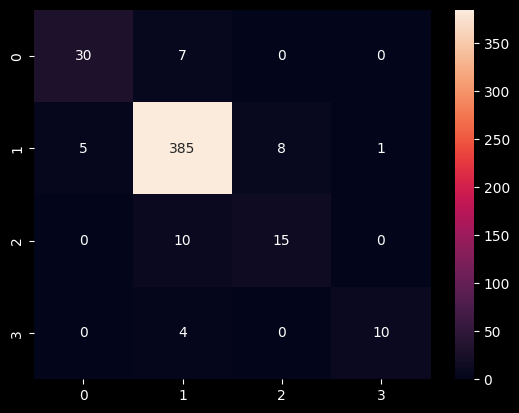

In [101]:
trainedforest1 = trainedforest.fit(X_train1,y_train1)

predictionforest1 = trainedforest.predict(X_test1)

sns.heatmap(confusion_matrix(y_test1, predictionforest1), annot = True, fmt = 'g')
print(classification_report(y_test1, predictionforest1))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83        37
           1       0.95      0.96      0.96       399
           2       0.62      0.60      0.61        25
           3       1.00      0.71      0.83        14

    accuracy                           0.93       475
   macro avg       0.86      0.77      0.81       475
weighted avg       0.93      0.93      0.93       475



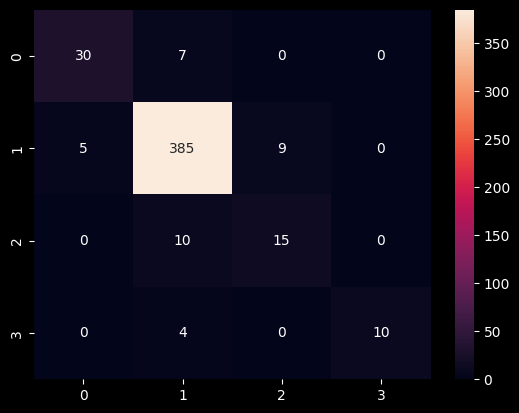

In [102]:
trainedforest1 = trainedforestRS.fit(X_train1,y_train1)

predictionforest1 = trainedforestRS.predict(X_test1)

sns.heatmap(confusion_matrix(y_test1, predictionforest1), annot = True, fmt = 'g')
print(classification_report(y_test1, predictionforest1))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        37
           1       0.96      0.96      0.96       399
           2       0.61      0.56      0.58        25
           3       0.92      0.79      0.85        14

    accuracy                           0.93       475
   macro avg       0.83      0.80      0.81       475
weighted avg       0.93      0.93      0.93       475



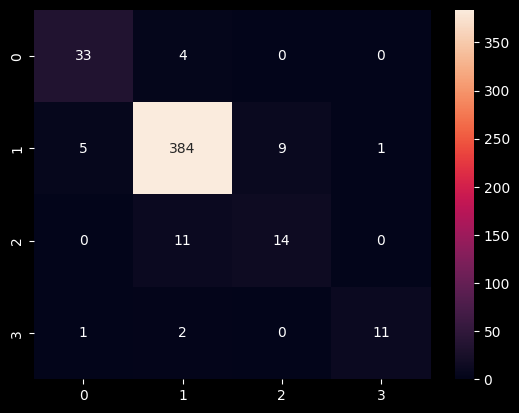

In [103]:
trainedforest1 = trainedforestGS.fit(X_train1,y_train1)

predictionforest1 = trainedforestGS.predict(X_test1)

sns.heatmap(confusion_matrix(y_test1, predictionforest1), annot = True, fmt = 'g')
print(classification_report(y_test1, predictionforest1))

### **Varios modelos**

#### **LogisticRegression**

Accuracy: 0.9304897314375987
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        59
           1       0.96      0.96      0.96       508
           2       0.80      0.84      0.82        43
           3       0.95      0.91      0.93        23

    accuracy                           0.93       633
   macro avg       0.88      0.86      0.87       633
weighted avg       0.93      0.93      0.93       633



<Axes: >

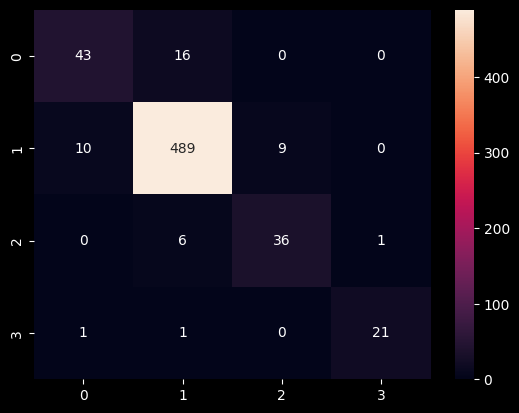

In [104]:
from sklearn.linear_model import LogisticRegression

modelo_lr = LogisticRegression(max_iter=500)
modelo_lr.fit(X_train, y_train)

y_pred_lr = modelo_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot = True, fmt = 'g')


#### **KNN**

Accuracy: 0.9383886255924171
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        59
           1       0.94      0.99      0.96       508
           2       1.00      0.49      0.66        43
           3       0.96      0.96      0.96        23

    accuracy                           0.94       633
   macro avg       0.96      0.80      0.86       633
weighted avg       0.94      0.94      0.93       633



<Axes: >

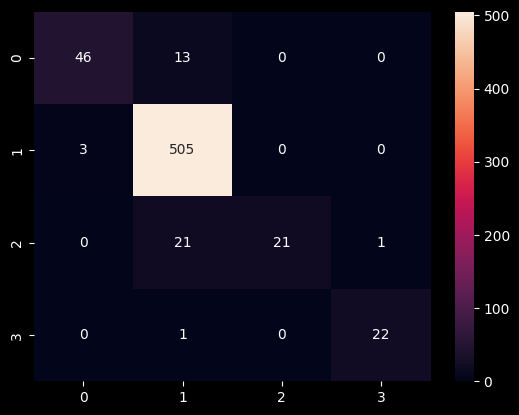

In [105]:
from sklearn.neighbors import KNeighborsClassifier

modelo_knn = KNeighborsClassifier(n_neighbors=5)
modelo_knn.fit(X_train, y_train)

y_pred_knn = modelo_knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot = True, fmt = 'g')

#### **SVC**

Accuracy: 0.933649289099526
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        59
           1       0.94      0.98      0.96       508
           2       0.87      0.47      0.61        43
           3       1.00      0.96      0.98        23

    accuracy                           0.93       633
   macro avg       0.93      0.81      0.85       633
weighted avg       0.93      0.93      0.93       633



<Axes: >

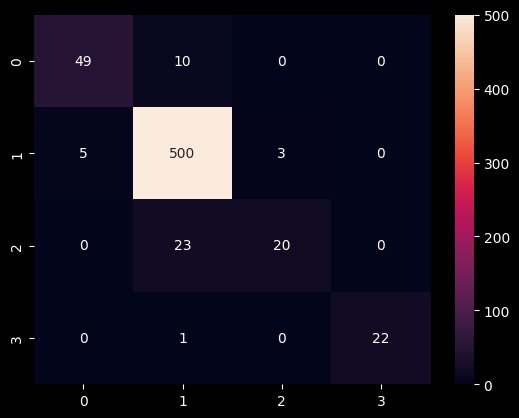

In [106]:
from sklearn.svm import SVC

modelo_svc = SVC(kernel='poly')
modelo_svc.fit(X_train, y_train)

y_pred_svc = modelo_svc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot = True, fmt = 'g')

#### **DecisionTree**

Accuracy: 0.9178515007898894
              precision    recall  f1-score   support

           0       0.84      0.81      0.83        59
           1       0.96      0.95      0.95       508
           2       0.62      0.74      0.67        43
           3       0.90      0.83      0.86        23

    accuracy                           0.92       633
   macro avg       0.83      0.83      0.83       633
weighted avg       0.92      0.92      0.92       633



<Axes: >

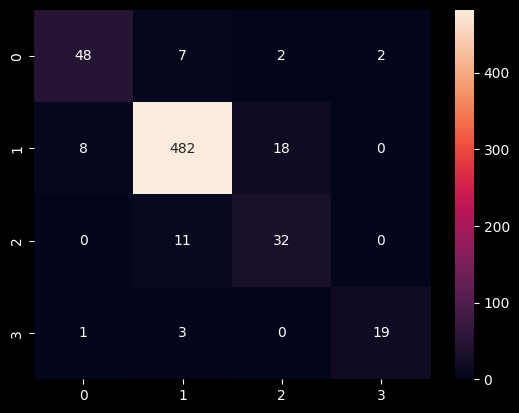

In [107]:
from sklearn.tree import DecisionTreeClassifier

modelo_tree = DecisionTreeClassifier(max_depth=15)
modelo_tree.fit(X_train, y_train)

y_pred_tree = modelo_tree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot = True, fmt = 'g')

#### **NaiveBayes**

Accuracy: 0.7804107424960506
              precision    recall  f1-score   support

           0       0.65      0.93      0.76        59
           1       0.98      0.75      0.85       508
           2       0.28      0.91      0.43        43
           3       0.95      0.91      0.93        23

    accuracy                           0.78       633
   macro avg       0.72      0.87      0.74       633
weighted avg       0.90      0.78      0.81       633



<Axes: >

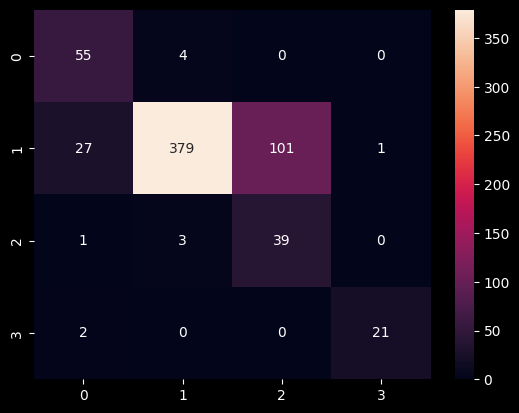

In [108]:
from sklearn.naive_bayes import GaussianNB

modelo_nb = GaussianNB()
modelo_nb.fit(X_train, y_train)

y_pred_nb = modelo_nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot = True, fmt = 'g')

#### **GradientBoosting**

Accuracy: 0.9510268562401264
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        59
           1       0.97      0.97      0.97       508
           2       0.83      0.88      0.85        43
           3       1.00      0.87      0.93        23

    accuracy                           0.95       633
   macro avg       0.92      0.89      0.90       633
weighted avg       0.95      0.95      0.95       633



<Axes: >

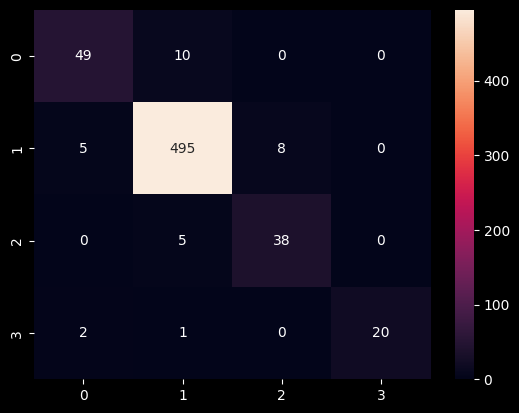

In [111]:
from sklearn.ensemble import GradientBoostingClassifier

modelo_gb = GradientBoostingClassifier(n_estimators=150)
modelo_gb.fit(X_train, y_train)
y_pred_gb = modelo_gb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot = True, fmt = 'g')

#### **NeuralNetwork**

Accuracy: 0.9605055292259084
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        59
           1       0.97      0.98      0.98       508
           2       0.95      0.86      0.90        43
           3       0.96      0.96      0.96        23

    accuracy                           0.96       633
   macro avg       0.94      0.91      0.92       633
weighted avg       0.96      0.96      0.96       633



c:\Users\zahid\Escritorio\ProyectoTSBM\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: >

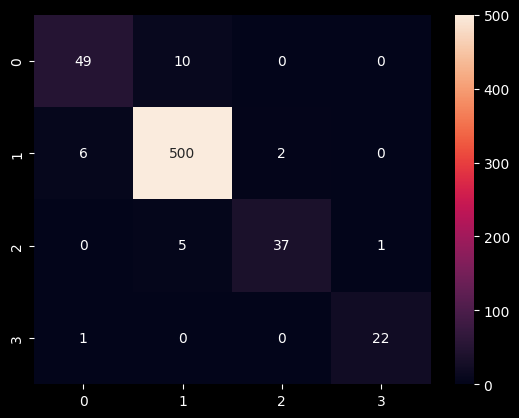

In [124]:
from sklearn.neural_network import MLPClassifier

modelo_mlp = MLPClassifier(solver = 'sgd',
                           activation='relu', 
                           alpha = 1e-5, 
                           hidden_layer_sizes = (350,), 
                           learning_rate = 'adaptive')
modelo_mlp.fit(X_train, y_train)
y_pred_mlp = modelo_mlp.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot = True, fmt = 'g')
